In [15]:
#Building a training data set
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA=False #while pre-processing data, we don't need to rebuild every time

class CatsVSDogs():
    IMG_SIZE=50 #to normalize images
    CATS="PetImages/Cat"
    DOGS="PetImages/Dog"
    LABELS={CATS:0, DOGS:1}

    training_data=[]
    #checking count to assure a balanced data
    catcount=0
    dogcount=0
    
    def make_training_data(self):
        for label in self.LABELS: #iterating through LABELS CATS and DOGS ie directories
            print(label)
            for f in tqdm(os.listdir(label)): #iterating through the images in a particular directory
                try:
                    path=os.path.join(label,f)
                    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) #img to grayscale
                    img=cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE)) #resizing images
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]]) #np.eye used to create one-hot vector to append class
                    if label==self.CATS:
                        self.catcount+=1
                    elif label==self.DOGS:
                        self.dogcount+=1
                except:#skipping through the corrupted images
                    pass

        np.random.shuffle(self.training_data)

        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)


if REBUILD_DATA:
    dogssvcats=CatsVSDogs()
    dogssvcats.make_training_data()
    training_data= np.array(dogssvcats.training_data, dtype=object)
    np.save("training_data.npy", training_data)



PetImages/Cat


100%|██████████| 12501/12501 [00:05<00:00, 2121.76it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:06<00:00, 1903.17it/s]


Cats:  12476
Dogs:  12470


In [16]:
training_data=np.load("training_data.npy", allow_pickle=True)
print(training_data[0])
#output [0,1] represents a dog, whereas [1.0] a cat

[array([[124, 115, 162, ..., 210, 166, 172],
        [168, 134, 166, ..., 163, 163, 161],
        [140, 167, 126, ..., 164, 182, 132],
        ...,
        [ 50,  48,  51, ..., 115, 179, 161],
        [ 48,  57,  51, ..., 174, 159, 211],
        [ 41,  82,  68, ..., 164, 191, 161]], dtype=uint8) array([0., 1.])]


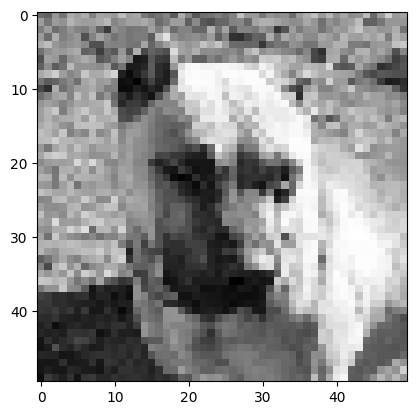

[0. 1.]


In [17]:
import matplotlib.pyplot as plt 
plt.imshow(training_data[0][0], cmap="gray")
plt.show()
print(training_data[0][1])

In [23]:
#Building the model layers

import torch
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5) #1 input, 32 conv features, kernel of 5*5 size
        self.conv2=nn.Conv2d(32,64,5)
        self.conv3=nn.Conv2d(64,128,5)

        x=torch.randn(50,50).view(-1,1,50,50) #converting to a tensor of 1*50*50 form
        self._to_linear=None #defining to find output of last conv layer that is to be passed to the linear layers

        self.convs(x)
        self.fc1=nn.Linear(self._to_linear,512)
        self.fc2=nn.Linear(512,2)

    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))

        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #gives input for 1st linear layer
        
        return x
    
    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1,self._to_linear)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x,dim=1) #Activation layer
    
net=Net()


torch.Size([128, 2, 2])


In [26]:
#Training the model

import torch.optim as optim 
optimizer= optim.Adam(net.parameters(), lr=0.001)
loss_function=nn.MSELoss() #use of mean squared error for one-hot vectors
X=np.array([i[0] for i in training_data])
X=torch.Tensor(X).view(-1,50,50)
X=X/255.0 #scaling image pixel values from range[0,255] to range[0,1]

y=torch.Tensor([i[1] for i in training_data])

VAL_PCT=0.1 # % of test data
val_size=int(len(X)*VAL_PCT)
print(val_size)

train_X=X[:-val_size]
train_y=y[:-val_size]
test_X=X[-val_size:] #separating out test data
test_y=y[-val_size:]

print(len(train_X))
print(len(test_X))

2494
22452
2494


In [31]:
BATCH_SIZE=100
EPOCHS=3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X),BATCH_SIZE)):
        batch_X=train_X[i:i+BATCH_SIZE].view(-1,1,50,50) #creating batches of data
        batch_y=train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        output=net(batch_X)
        loss=loss_function(output,batch_y) 
        loss.backward()
        optimizer.step()

  0%|          | 1/225 [00:00<00:34,  6.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<00:29,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:00<00:30,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:00<00:29,  7.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:01<00:29,  7.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:01<00:30,  7.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:01<00:29,  7.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:02<00:28,  7.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:02<00:28,  7.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:02<00:27,  7.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:02<00:26,  7.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:03<00:26,  7.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:03<00:26,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:03<00:27,  7.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:03<00:26,  7.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:04<00:27,  7.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:04<00:26,  7.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:04<00:26,  7.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:05<00:25,  7.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:05<00:25,  7.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:05<00:25,  7.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:05<00:24,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:06<00:24,  7.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:06<00:25,  6.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:06<00:25,  7.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:06<00:24,  7.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:07<00:23,  7.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:07<00:23,  7.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:07<00:23,  7.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:08<00:22,  7.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:08<00:22,  7.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:08<00:21,  7.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:08<00:21,  7.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:09<00:21,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:09<00:21,  7.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:09<00:21,  7.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:09<00:20,  7.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:10<00:20,  7.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:10<00:20,  7.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:10<00:20,  7.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:11<00:19,  7.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:11<00:19,  7.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:11<00:18,  7.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:11<00:18,  7.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:12<00:18,  7.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:12<00:18,  7.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:12<00:19,  6.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:13<00:19,  6.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:13<00:18,  6.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:13<00:17,  7.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:13<00:17,  7.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:14<00:17,  7.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:14<00:16,  7.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:14<00:16,  7.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:14<00:15,  7.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:15<00:15,  7.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:15<00:15,  7.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:15<00:15,  7.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:16<00:14,  7.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:16<00:14,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:16<00:14,  7.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:16<00:13,  7.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:17<00:13,  7.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:17<00:13,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:17<00:12,  7.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:17<00:12,  7.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:18<00:12,  7.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:18<00:12,  7.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:18<00:12,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:19<00:11,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:19<00:11,  7.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:19<00:11,  7.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:19<00:10,  7.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:20<00:10,  7.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:20<00:10,  7.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:20<00:09,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:20<00:09,  7.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:21<00:09,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:21<00:09,  7.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:21<00:08,  7.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:22<00:08,  7.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:22<00:08,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:22<00:08,  7.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:22<00:07,  7.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:23<00:07,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:23<00:07,  7.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:23<00:07,  7.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:23<00:06,  7.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:24<00:06,  7.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:24<00:06,  7.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:24<00:05,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:25<00:05,  7.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:25<00:05,  7.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:25<00:05,  7.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:25<00:05,  6.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:26<00:04,  7.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:26<00:04,  7.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:26<00:04,  7.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:26<00:03,  7.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:27<00:03,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:27<00:03,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:27<00:02,  7.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:28<00:02,  7.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:28<00:02,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:28<00:02,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:28<00:01,  7.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:29<00:01,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:29<00:01,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:29<00:01,  7.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:29<00:00,  7.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:30<00:00,  7.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:30<00:00,  7.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<00:30,  7.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<00:30,  7.35it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<00:30,  7.32it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:30,  7.33it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:00<00:29,  7.34it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:00<00:32,  6.74it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:00<00:31,  7.01it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:01<00:30,  7.00it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:01<00:30,  7.14it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:01<00:29,  7.28it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:01<00:28,  7.57it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:01<00:28,  7.44it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:01<00:28,  7.36it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:01<00:28,  7.31it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:02<00:29,  7.15it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:02<00:30,  6.93it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:02<00:29,  7.06it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:02<00:29,  7.13it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:02<00:28,  7.15it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:02<00:28,  7.20it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:02<00:28,  7.20it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:03<00:27,  7.27it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:03<00:27,  7.28it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:03<00:27,  7.26it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:03<00:27,  7.31it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:03<00:27,  7.34it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:03<00:27,  7.30it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:03<00:27,  7.21it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:04<00:27,  7.17it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:04<00:27,  7.09it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:04<00:27,  7.10it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:04<00:27,  7.00it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:04<00:26,  7.16it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:04<00:26,  7.16it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:04<00:27,  6.96it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:05<00:27,  6.77it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:05<00:27,  6.88it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:05<00:27,  6.88it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:05<00:26,  6.89it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:05<00:26,  6.98it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:05<00:26,  7.03it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:05<00:26,  7.02it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:06<00:26,  7.00it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:06<00:25,  7.12it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:06<00:26,  6.92it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:06<00:25,  6.93it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:06<00:25,  7.09it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:06<00:25,  7.06it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:06<00:24,  7.09it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:07<00:24,  7.15it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:07<00:23,  7.26it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:07<00:23,  7.28it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:07<00:23,  7.24it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:07<00:23,  7.15it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:07<00:23,  7.21it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:07<00:23,  7.25it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:07<00:23,  7.30it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:08<00:22,  7.27it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:08<00:22,  7.29it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:08<00:22,  7.22it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:08<00:22,  7.26it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:08<00:22,  7.30it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:08<00:22,  7.29it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:08<00:22,  7.31it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:09<00:21,  7.31it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:09<00:21,  7.23it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:09<00:21,  7.24it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:09<00:21,  7.18it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:09<00:21,  7.24it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:09<00:21,  7.25it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:09<00:21,  7.33it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:10<00:21,  7.06it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:10<00:22,  6.87it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:10<00:21,  7.14it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:10<00:20,  7.23it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:10<00:20,  7.34it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:10<00:19,  7.49it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:10<00:19,  7.59it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:10<00:19,  7.55it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:11<00:18,  7.69it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:11<00:18,  7.70it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:11<00:18,  7.67it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:11<00:19,  7.32it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:11<00:19,  7.21it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:11<00:19,  7.17it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:11<00:19,  7.13it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:12<00:19,  7.13it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:12<00:19,  7.16it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:12<00:19,  7.02it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:12<00:18,  7.11it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:12<00:18,  7.35it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:12<00:17,  7.52it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:12<00:17,  7.60it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:13<00:16,  7.75it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:13<00:16,  7.70it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:13<00:16,  7.70it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:13<00:16,  7.75it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:13<00:16,  7.79it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:13<00:16,  7.77it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:13<00:15,  7.83it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:13<00:15,  7.85it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:14<00:15,  7.72it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:14<00:16,  7.39it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:14<00:16,  7.38it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:14<00:16,  7.36it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:14<00:15,  7.50it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:14<00:16,  7.30it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:14<00:16,  7.26it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:15<00:15,  7.40it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:15<00:16,  7.04it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:15<00:15,  7.21it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:15<00:15,  7.17it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:15<00:15,  7.25it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:15<00:15,  7.30it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:15<00:15,  7.28it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:15<00:14,  7.39it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:16<00:14,  7.53it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:16<00:14,  7.27it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:16<00:14,  7.13it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:16<00:14,  7.03it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:16<00:14,  6.93it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:16<00:14,  7.05it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:16<00:14,  7.17it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:17<00:13,  7.25it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:17<00:13,  7.30it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:17<00:13,  7.35it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:17<00:13,  7.44it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:17<00:13,  7.43it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:17<00:13,  7.24it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:17<00:12,  7.32it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:18<00:13,  7.17it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:18<00:12,  7.26it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:18<00:12,  7.30it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:18<00:12,  7.27it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:18<00:12,  7.21it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:18<00:12,  7.39it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:18<00:11,  7.47it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:19<00:11,  7.50it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:19<00:11,  7.45it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:19<00:11,  7.34it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:19<00:11,  7.28it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:19<00:11,  7.24it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:19<00:11,  7.25it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:19<00:10,  7.41it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:19<00:10,  7.50it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:20<00:10,  7.57it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:20<00:10,  7.61it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:20<00:10,  7.62it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:20<00:09,  7.61it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:20<00:09,  7.69it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:20<00:09,  7.72it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:20<00:09,  7.79it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:20<00:09,  7.71it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:21<00:09,  7.75it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:21<00:09,  7.76it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:21<00:08,  7.71it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:21<00:08,  7.74it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:21<00:08,  7.75it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:21<00:08,  7.71it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:21<00:08,  7.74it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:22<00:08,  7.77it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:22<00:08,  7.78it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:22<00:08,  7.73it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:22<00:07,  7.73it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:22<00:07,  7.73it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:22<00:07,  7.73it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:22<00:07,  7.79it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:22<00:07,  7.71it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:23<00:07,  7.75it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:23<00:07,  7.73it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:23<00:06,  7.76it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:23<00:06,  7.74it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:23<00:06,  7.74it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:23<00:06,  7.79it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:23<00:06,  7.74it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:23<00:06,  7.79it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:24<00:06,  7.76it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:24<00:06,  7.77it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:24<00:05,  7.80it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:24<00:05,  7.81it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:24<00:05,  7.84it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:24<00:05,  7.80it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:24<00:05,  7.85it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:24<00:05,  7.86it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:25<00:05,  7.86it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:25<00:04,  7.83it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:25<00:04,  7.84it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:25<00:04,  7.78it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:25<00:04,  7.75it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:25<00:04,  7.73it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:25<00:04,  7.78it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:26<00:04,  7.80it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:26<00:04,  7.76it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:26<00:03,  7.76it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:26<00:03,  7.68it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [00:26<00:03,  7.70it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:26<00:03,  7.68it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:26<00:03,  7.69it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:26<00:03,  7.72it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [00:27<00:03,  7.73it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:27<00:03,  7.73it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:27<00:02,  7.71it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:27<00:02,  7.70it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [00:27<00:02,  7.78it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:27<00:02,  7.74it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [00:27<00:02,  7.78it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:27<00:02,  7.77it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [00:28<00:02,  7.76it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:28<00:02,  7.78it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:28<00:01,  7.81it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:28<00:01,  7.78it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:28<00:01,  7.77it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:28<00:01,  7.76it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [00:28<00:01,  7.78it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:28<00:01,  7.80it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [00:29<00:01,  7.69it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:29<00:01,  7.67it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [00:29<00:00,  7.68it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:29<00:00,  7.73it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [00:29<00:00,  7.71it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:29<00:00,  7.72it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:29<00:00,  7.74it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:30<00:00,  7.80it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<00:27,  8.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<00:28,  7.78it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<00:28,  7.72it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:28,  7.77it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:00<00:28,  7.80it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:00<00:27,  7.87it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:00<00:27,  7.84it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:01<00:27,  7.84it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:01<00:27,  7.85it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:01<00:27,  7.82it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:01<00:27,  7.79it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:01<00:27,  7.84it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:01<00:27,  7.85it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:01<00:27,  7.78it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:01<00:27,  7.65it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:02<00:27,  7.67it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:02<00:27,  7.60it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:02<00:27,  7.61it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:02<00:26,  7.68it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:02<00:26,  7.66it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:02<00:26,  7.60it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:02<00:26,  7.66it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:02<00:25,  7.77it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:03<00:25,  7.78it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:03<00:26,  7.66it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:03<00:26,  7.48it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:03<00:26,  7.40it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:03<00:27,  7.27it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:03<00:26,  7.27it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:03<00:26,  7.23it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:04<00:26,  7.42it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:04<00:25,  7.58it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:04<00:24,  7.71it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:04<00:24,  7.82it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:04<00:24,  7.83it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:04<00:23,  7.89it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:04<00:23,  7.91it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:04<00:23,  7.94it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:05<00:23,  7.88it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:05<00:23,  7.89it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:05<00:23,  7.87it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:05<00:23,  7.91it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:05<00:23,  7.89it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:05<00:23,  7.87it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:05<00:23,  7.82it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:05<00:22,  7.79it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:06<00:22,  7.80it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:06<00:22,  7.83it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:06<00:22,  7.82it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:06<00:22,  7.85it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:06<00:22,  7.82it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:06<00:22,  7.86it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:06<00:22,  7.80it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:06<00:22,  7.65it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:07<00:22,  7.58it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:07<00:21,  7.71it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:07<00:21,  7.77it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:07<00:21,  7.78it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:07<00:21,  7.85it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:07<00:21,  7.84it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:07<00:20,  7.93it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:08<00:20,  7.91it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:08<00:20,  7.77it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:08<00:21,  7.57it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:08<00:20,  7.64it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:08<00:20,  7.75it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:08<00:20,  7.78it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:08<00:19,  7.88it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:08<00:19,  7.92it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:09<00:19,  7.97it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:09<00:19,  7.90it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:09<00:19,  7.90it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:09<00:19,  7.83it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:09<00:19,  7.82it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:09<00:19,  7.82it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:09<00:19,  7.81it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:09<00:18,  7.86it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:10<00:18,  7.77it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:10<00:18,  7.78it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:10<00:18,  7.78it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:10<00:18,  7.87it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:10<00:18,  7.87it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:10<00:19,  7.40it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:10<00:18,  7.50it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:10<00:18,  7.65it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:11<00:17,  7.77it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:11<00:17,  7.83it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:11<00:17,  7.84it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:11<00:17,  7.85it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:11<00:17,  7.87it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:11<00:17,  7.84it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:11<00:16,  7.84it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:11<00:16,  7.82it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:12<00:16,  7.82it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:12<00:16,  7.90it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:12<00:16,  7.86it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:12<00:16,  7.92it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:12<00:16,  7.87it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:12<00:15,  7.96it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:12<00:15,  7.88it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:12<00:15,  7.91it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:13<00:15,  7.91it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:13<00:15,  7.91it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:13<00:15,  7.86it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:13<00:15,  7.87it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:13<00:14,  7.93it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:13<00:14,  7.92it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:13<00:14,  7.92it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:14<00:14,  7.96it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:14<00:14,  7.98it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:14<00:14,  8.00it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:14<00:14,  7.97it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:14<00:14,  8.00it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:14<00:13,  7.96it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:14<00:13,  8.09it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:14<00:13,  8.01it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:15<00:13,  7.99it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:15<00:13,  7.85it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:15<00:13,  7.78it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:15<00:13,  7.84it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:15<00:13,  7.89it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:15<00:13,  7.86it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:15<00:13,  7.81it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:15<00:12,  7.87it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:16<00:12,  7.86it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:16<00:12,  7.94it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:16<00:12,  7.78it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:16<00:12,  7.86it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:16<00:12,  7.84it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:16<00:12,  7.88it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:16<00:11,  7.94it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:16<00:11,  7.94it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:17<00:11,  7.95it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:17<00:11,  7.95it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:17<00:11,  7.89it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:17<00:11,  7.89it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:17<00:11,  7.87it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:17<00:10,  7.92it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:17<00:10,  7.93it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:17<00:10,  7.87it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:18<00:10,  7.83it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:18<00:10,  7.77it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:18<00:10,  7.86it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:18<00:10,  8.01it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:18<00:09,  8.00it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:18<00:09,  7.92it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:18<00:09,  7.94it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:18<00:09,  8.00it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:19<00:09,  8.06it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:19<00:09,  8.04it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:19<00:09,  8.06it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:19<00:09,  8.05it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:19<00:08,  8.11it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:19<00:08,  8.12it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:19<00:08,  8.14it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:19<00:08,  8.07it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:20<00:08,  8.08it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:20<00:08,  8.06it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:20<00:08,  8.02it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:20<00:08,  7.99it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:20<00:08,  7.98it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:20<00:07,  7.97it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:20<00:07,  7.96it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:20<00:07,  7.99it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:21<00:07,  7.94it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:21<00:07,  7.93it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:21<00:07,  7.98it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:21<00:07,  8.02it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:21<00:06,  8.03it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:21<00:06,  8.06it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:21<00:06,  8.08it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:21<00:06,  7.99it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:22<00:06,  8.02it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:22<00:06,  7.93it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:22<00:06,  7.97it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:22<00:06,  7.78it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:22<00:06,  7.82it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:22<00:06,  7.70it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:22<00:05,  7.79it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:22<00:05,  7.84it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:23<00:05,  7.81it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:23<00:05,  7.88it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:23<00:05,  7.73it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:23<00:05,  7.52it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:23<00:05,  7.58it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:23<00:05,  7.54it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:23<00:04,  7.61it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:23<00:04,  7.68it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:24<00:04,  7.75it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:24<00:04,  7.13it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:24<00:04,  7.35it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:24<00:04,  7.55it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:24<00:04,  7.66it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:24<00:03,  7.75it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:24<00:03,  7.81it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [00:25<00:03,  7.89it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:25<00:03,  7.84it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:25<00:03,  7.93it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:25<00:03,  7.81it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [00:25<00:03,  7.89it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:25<00:03,  7.92it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:25<00:02,  7.99it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:25<00:02,  7.95it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [00:26<00:02,  8.01it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:26<00:02,  7.90it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [00:26<00:02,  7.28it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:26<00:02,  7.45it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [00:26<00:02,  7.35it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:26<00:02,  7.47it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:26<00:02,  7.39it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:27<00:01,  7.35it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:27<00:01,  7.34it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:27<00:01,  7.22it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [00:27<00:01,  7.32it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:27<00:01,  6.46it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [00:27<00:01,  6.73it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:27<00:01,  6.86it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [00:28<00:00,  7.05it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:28<00:00,  6.99it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [00:28<00:00,  7.22it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:28<00:00,  7.29it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:28<00:00,  7.17it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:28<00:00,  7.35it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:28<00:00,  7.78it/s]

torch.Size([128, 2, 2])


In [32]:
correct=0
total=0
with torch.no_grad():
    for i in tqdm(range(len(test_X))): #finding correctness of model using test data
        real_class= torch.argmax(test_y[i])
        net_out= net(test_X[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_out)
        if predicted_class== real_class:
            correct+=1
        total+=1

print("Accuracy: ", round(correct/total,3))

  5%|▍         | 114/2494 [00:00<00:04, 572.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  9%|▉         | 235/2494 [00:00<00:03, 589.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 15%|█▍        | 372/2494 [00:00<00:03, 649.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 18%|█▊        | 437/2494 [00:00<00:03, 570.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 22%|██▏       | 557/2494 [00:00<00:03, 579.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 27%|██▋       | 680/2494 [00:01<00:03, 595.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 32%|███▏      | 800/2494 [00:01<00:02, 588.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 37%|███▋      | 924/2494 [00:01<00:02, 603.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 42%|████▏     | 1046/2494 [00:01<00:02, 601.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 47%|████▋     | 1168/2494 [00:01<00:02, 580.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 52%|█████▏    | 1291/2494 [00:02<00:02, 594.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 57%|█████▋    | 1414/2494 [00:02<00:01, 603.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 62%|██████▏   | 1542/2494 [00:02<00:01, 611.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 67%|██████▋   | 1668/2494 [00:02<00:01, 615.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 72%|███████▏  | 1796/2494 [00:02<00:01, 621.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 77%|███████▋  | 1925/2494 [00:03<00:00, 629.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 82%|████████▏ | 2053/2494 [00:03<00:00, 614.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 88%|████████▊ | 2203/2494 [00:03<00:00, 650.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 94%|█████████▎| 2334/2494 [00:03<00:00, 616.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 99%|█████████▉| 2464/2494 [00:04<00:00, 630.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:04<00:00, 609.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.764
